### Load Libraries

In [1]:
from __future__ import unicode_literals, print_function, division

import glob
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
import pandas as pd
import pickle
import unicodedata
import random
import regex
import spacy
import string
import sys
np.set_printoptions(threshold=sys.maxsize)
import time
import timeit

from tqdm import tqdm_notebook
from apex import amp

import torch
import torch.nn as nn
import torchtext
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, RMSprop
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchtext.data import Field, BucketIterator, TabularDataset, Iterator

seed = 42
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

nlp = spacy.load('en_core_web_md')
nlp.max_length = 2000000

In [2]:
USE_AMP = True
DEVICE = torch.device('cuda:0' if USE_AMP else 'cpu')
MODEL_NAME = 'gru-v5-840b300d'
MODEL_PATH = f'./saved-data/models/{MODEL_NAME}-state-dict.pt'
MODEL_PATH_FINAL = f'./saved-data/models/{MODEL_NAME}-final-state-dict.pt'
GENERATE_SAMPLES = False
SAMPLE_SIZE = 200
AUTHORS = [
    'Andrew Lang',
    'Anthony Trollope',
    'Baronness Orczy',
    'Benjamin Disraeli',
    'Bret Harte',
    'Charles Darwin',
    'Charles Dickens',
    'Charles Kingsley',
    'Charlotte Mary Yonge',
    'Daniel Defoe',
]

### Generate Labeled Samples

In [3]:
if GENERATE_SAMPLES:
    paths = glob.glob('labeled-text/*')
    paths.sort()
    all_titles = [fn.split('/')[-1].split('___')[1][:-4] for fn in paths]
    all_authors = [fn.split('/')[-1].split('___')[0] for fn in paths]
    all_texts = [
        open(path, errors='ignore', mode='r')\
        .read().replace('\n', ' ').replace('\r', '')
             for path in paths
    ]
    
    author_texts = {author:{'texts': [], 'train': [], 'val': [], 'test': []} for author in AUTHORS}
    for author, text in zip(all_authors, all_texts):
        if author in list(author_texts.keys()):
            author_texts[author]['texts'].append(text)
    
    train_df = pd.DataFrame(columns=['text', 'author'])
    val_df = pd.DataFrame(columns=['text', 'author'])
    test_df = pd.DataFrame(columns=['text', 'author'])
    for author in tqdm_notebook(AUTHORS):
        num_of_texts = len(author_texts[author]['texts'])
        train_count = int(0.8 * num_of_texts)
        val_count = int(0.5 * (num_of_texts - train_count))
        test_count = num_of_texts - train_count - val_count
        
        author_texts[author]['train'] = author_texts[author]['texts'][:train_count]
        author_texts[author]['val'] = author_texts[author]['texts'][train_count:train_count+val_count]
        author_texts[author]['test'] = author_texts[author]['texts'][train_count+val_count:]
        
        for doc in nlp.pipe(author_texts[author]['train'], disable=['tagger', 'parser', 'ner']):
            train_df = pd.concat([train_df] + [pd.DataFrame(
                    [[''.join(token.text_with_ws for token in doc[idx:idx+SAMPLE_SIZE]), author]], columns=['text', 'author']
                ) for idx in range(0, len(doc)-SAMPLE_SIZE, SAMPLE_SIZE)], ignore_index=True)
        for doc in nlp.pipe(author_texts[author]['val'], disable=['tagger', 'parser', 'ner']):
            val_df = pd.concat([val_df] + [pd.DataFrame(
                    [[''.join(token.text_with_ws for token in doc[idx:idx+SAMPLE_SIZE]), author]], columns=['text', 'author']
                ) for idx in range(0, len(doc)-SAMPLE_SIZE, SAMPLE_SIZE)], ignore_index=True)
        for doc in nlp.pipe(author_texts[author]['test'], disable=['tagger', 'parser', 'ner']):
            test_df = pd.concat([test_df] + [pd.DataFrame(
                    [[''.join(token.text_with_ws for token in doc[idx:idx+SAMPLE_SIZE]), author]], columns=['text', 'author']
                ) for idx in range(0, len(doc)-SAMPLE_SIZE, SAMPLE_SIZE)], ignore_index=True)
    
    train_df.to_csv(f'saved-data/csv/{SAMPLE_SIZE}-token-train.csv', index=False)
    val_df.to_csv(f'saved-data/csv/{SAMPLE_SIZE}-token-val.csv', index=False)
    test_df.to_csv(f'saved-data/csv/{SAMPLE_SIZE}-token-test.csv', index=False)

### Load Data

In [4]:
def tokenizer(text):
    return [tok.text for tok in nlp.tokenizer(text)]

BATCH_SIZE = 128
VAL_BATCH_SIZE = 128
TEXT = Field(sequential=True, tokenize=tokenizer, lower=True, batch_first=True)
LABEL = Field(sequential=False, batch_first=True)

train_df = pd.read_csv(f'saved-data/csv/{SAMPLE_SIZE}-token-train.csv')
val_df = pd.read_csv(f'saved-data/csv/{SAMPLE_SIZE}-token-val.csv')
val_df = val_df.sample(n=5000)
test_df = pd.read_csv(f'saved-data/csv/{SAMPLE_SIZE}-token-test.csv')

train_td, val_td, test_td = TabularDataset.splits(
    path='saved-data/csv/', train=f'{SAMPLE_SIZE}-token-train.csv',
    validation=f'{SAMPLE_SIZE}-token-val.csv', test=f'{SAMPLE_SIZE}-token-test.csv',
    format='csv', skip_header=True, fields=[('text', TEXT), ('label', LABEL)])

TEXT.build_vocab(train_td, min_freq=5, vectors='glove.840B.300d')
text_vocab = TEXT.vocab
LABEL.build_vocab(train_td)
label_vocab = LABEL.vocab

train_iter, val_iter, test_iter = Iterator.splits(
    (train_td, val_td, test_td),
    sort_key=lambda x: len(x.text),
    shuffle=True,
    sort_within_batch=False,
    batch_sizes=(BATCH_SIZE, VAL_BATCH_SIZE, VAL_BATCH_SIZE),
    device=DEVICE)

### Define Model

In [5]:
class GruTextClassifier(nn.Module):
    def __init__(self, vocab, hidden_size, num_layers, output_size, drop_prob, is_bidir):
        super(GruTextClassifier, self).__init__()
        
        self.vocab_size = len(vocab)
        self.embed_size = vocab.vectors.shape[1]
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.drop_prob = drop_prob
        self.is_bidir = is_bidir
        
        self.embed = nn.Embedding(self.vocab_size, self.embed_size)
        
        self.gru = nn.GRU(self.embed_size, hidden_size, num_layers, batch_first=True,
                          dropout=drop_prob, bidirectional=is_bidir)
        
        self.dropout = nn.Dropout(drop_prob)
        
        if is_bidir:
            self.fc = nn.Linear(hidden_size * 2, output_size)
        else:
            self.fc = nn.Linear(hidden_size, output_size)
            
        self.softmax = nn.LogSoftmax(dim=1)
        
        self.init_weights(vocab)

    def init_weights(self, vocab):
        initrange = 0.5
        self.embed.weight.data.copy_(vocab.vectors)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        if self.is_bidir:
            hidden = weight.new(self.num_layers * 2, batch_size, self.hidden_size).zero_().to(DEVICE)
        else:
            hidden = weight.new(self.num_layers, batch_size, self.hidden_size).zero_().to(DEVICE)
        return hidden
    
    def forward(self, x):
        batch_size, seq_len = x.shape
        if seq_len > 200:
            x = x[:, 0:200]
            seq_len = x.shape[1]
        
        hidden = self.init_hidden(batch_size)
        
        x_embed = self.embed(x)
        
        out, hidden = self.gru(x_embed, hidden)
        out = out.transpose(0,1)
        out = out[-1, :, :]
        out = self.dropout(out)
        
        out = self.fc(out)
        out = self.softmax(out)
        
        return out, hidden

### Train Model

In [6]:
model = GruTextClassifier(
    vocab=TEXT.vocab, hidden_size=512, num_layers=2, output_size=len(AUTHORS)+1,
    drop_prob=0.5, is_bidir=False).to(DEVICE)

optimizer = Adam(model.parameters(), eps=1e-4, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=4)
criterion = torch.nn.CrossEntropyLoss().to(DEVICE)

if USE_AMP:
    model, optimizer = amp.initialize(
        model, optimizer, opt_level='O1', keep_batchnorm_fp32=None, loss_scale='dynamic')

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


In [7]:
n_epochs = 5
step_count = 0
val_loss_min = None
hist_dict = {'steps':[], 'loss':[], 'val_loss':[], 'val_acc':[]}
for epoch in range(n_epochs):
    start = timeit.default_timer()
    
    for data in train_iter:
        inputs, labels = data.text.to(DEVICE), data.label.to(DEVICE)
        model.zero_grad()
        output, hidden = model(inputs)
        loss = criterion(output, labels)
        
        if USE_AMP:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()
        
        optimizer.step()
        
        # Validate model every 500 batches
        if step_count % 500 == 0:
            val_losses = []
            val_acc = 0
            
            model.eval()
            for val_data in val_iter:
                with torch.no_grad():
                    val_inputs, val_labels = val_data.text.to(DEVICE), val_data.label.to(DEVICE)
                    val_out, val_hidden = model(val_inputs)
                    val_loss = criterion(val_out, val_labels)
                    val_losses.append(val_loss.item())
                    val_acc += (val_out.argmax(1) == val_labels).sum().item()
            model.train()

            val_loss_mean = np.mean(val_losses)
            val_acc = val_acc / (len(val_iter.dataset.examples))
            scheduler.step(val_loss_mean)

            hist_dict['steps'].append(step_count)
            hist_dict['loss'].append(loss.item())
            hist_dict['val_loss'].append(val_loss_mean)
            hist_dict['val_acc'].append(val_acc)

            print('Epoch: {}/{}...'.format(epoch+1, n_epochs),
                  'Step: {}...'.format(step_count),
                  'Loss: {:.6f}...'.format(loss.item()),
                  'Val Loss: {:.6f}...'.format(val_loss_mean),
                  'Val Acc: {:.6f}'.format(val_acc))

            if val_loss_min is None:
                val_loss_min = val_loss_mean

            if val_loss_mean <= val_loss_min:
                print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model...'.format(val_loss_min, val_loss_mean))
                torch.save(model.state_dict(), MODEL_PATH)
                val_loss_min = val_loss_mean
            
        step_count += 1
    
    seconds = int(timeit.default_timer() - start)
    minutes = seconds // 60
    print(f'Epoch: {epoch + 1}... Loss: {loss.item():.6f}... Time: {minutes}:{seconds % 60}')

Epoch: 1/5... Step: 0... Loss: 2.560323... Val Loss: 4.001451... Val Acc: 0.160738
Validation loss decreased (4.001451 --> 4.001451). Saving model...
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Epoch: 1/5... Step: 500... Loss: 0.581944... Val Loss: 0.833095... Val Acc: 0.721954
Validation loss decreased (4.001451 --> 0.833095). Saving model...
Epoch: 1/5... Step: 1000... Loss: 0.145256... Val Loss: 0.667936... Val Acc: 0.805858
Validation loss decreased (0.833095 --> 0.667936). Saving model...
Epoch: 1... Loss: 0.034625... Time: 1:18
Epoch: 2/5... Step: 1500... Loss: 0.245750... Val Loss: 0.753982... Val Acc: 0.806905
Epoch: 2/5... Step: 2000... Loss: 0.142821... Val Loss: 0.614319... Val Acc: 0.845584
Validation loss decreased (0.667936 --> 0.614319). Saving model...
Epoch: 2/5... Step: 2500... Loss: 0.128519... Val Loss: 0.705726... Val Acc: 0.840609
Epoch: 2... Loss: 0

In [8]:
torch.save(model.state_dict(), MODEL_PATH_FINAL)

### Evaluate Model

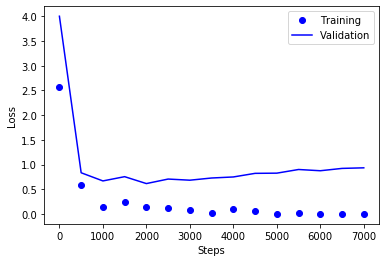

In [9]:
plt.plot(hist_dict['steps'], hist_dict['loss'], 'bo', label='Training')
plt.plot(hist_dict['steps'], hist_dict['val_loss'], 'b', label='Validation')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

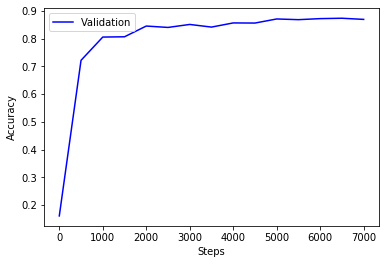

In [10]:
plt.plot(hist_dict['steps'], hist_dict['val_acc'], 'b', label='Validation')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [11]:
def test(model, tt_iter):
    acc = 0
    
    model.eval()
    for data in tqdm_notebook(tt_iter):
        with torch.no_grad():
            inputs, labels = data.text.to(DEVICE), data.label.to(DEVICE)
            output, hidden = model(inputs)
            acc += (output.argmax(1) == labels).sum().item()
    model.train()
    
    return acc / len(tt_iter.dataset.examples)

In [12]:
print(test(model, test_iter))


0.829940119760479


In [13]:
model.load_state_dict(torch.load(MODEL_PATH))
print(test(model, test_iter))


0.8106415739948674
